In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
import scipy.linalg
import scipy.signal

from rfest import build_design_matrix
from rfest import ARD, ASD, ALD, splineLG

from sklearn.metrics import r2_score

The following script to simulate correlated noise data is ported from matlab code by [leaduncker](https://github.com/leaduncker/SimpleEvidenceOpt).

# Make 2D Receptive Field

In [2]:
dt = 1/60 # time bin size
nt = 30
nx = 40
tt = np.arange(-nt*dt, 0, dt)

kt1 = scipy.stats.gamma.pdf(-tt, 4, scale=.025)
kt2 = scipy.stats.gamma.pdf(-tt, 6, scale=.03)
kt1 /= np.linalg.norm(kt1)
kt2 /= -np.linalg.norm(kt2)

kt = np.vstack([kt1, kt2]).T

xx = np.linspace(-2, 2, nx)

kx1 = np.cos(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)
kx2 = np.sin(2*np.pi*xx/2 + np.pi/5) * np.exp(-1/(2*0.35**2) * xx**2)

kx1 /= np.linalg.norm(kx1)
kx2 /= np.linalg.norm(kx2)

kx = np.vstack([kx1, kx2])

k = kt @ kx
k_norm = k/np.linalg.norm(k)

Text(0.5, 1.0, 'True Receptive Field')

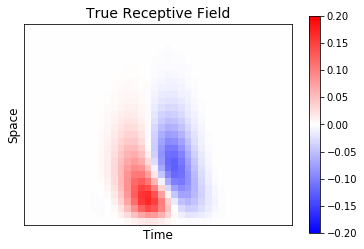

In [3]:
plt.imshow(k_norm, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Time', fontsize=12)
plt.ylabel('Space', fontsize=12)
plt.title('True Receptive Field', fontsize=14)

# Simulate Correlated Noise and Response

In [4]:
N = 5000 # sample size
signse = 1 # noise stdev
Sigma = scipy.linalg.toeplitz(np.exp(-(np.arange(0, nx)) / (nx/6))) # correlated (AR1) stim covariance

mu = np.zeros(nx)
np.random.seed(2046)
Stim = np.random.multivariate_normal(mu, Sigma, N) 
X = build_design_matrix(Stim, nt)
y = X @ k.flatten() + signse * np.random.randn(N)

dims = [nt, nx] # Receptive fields dims

# Run ASD, ALD, splineLG

In [5]:
asd = ASD(X, y, dims, compute_mle=False)
asd.fit(p0=np.array([1. , 1., 7., 7.,]), num_iters=10)

/Users/ziweih/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/jax/lib/xla_bridge.py:114: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Iter	σ	ρ	δt	δs	cost
   0	1.010	1.010	7.010	7.010	17696.130
   1	1.020	1.019	7.020	7.020	17490.080
   2	1.030	1.024	7.030	7.029	17242.692
   3	1.040	1.030	7.040	7.038	17023.409
   4	1.050	1.037	7.050	7.047	16833.348
   5	1.060	1.042	7.059	7.057	16626.441
   6	1.070	1.049	7.068	7.061	16427.582
   7	1.079	1.048	7.073	7.061	16239.753
   8	1.089	1.048	7.080	7.062	16043.165
   9	1.099	1.051	7.087	7.066	15853.496
Stop: reached 10 steps, final cost=15853.49619.


In [6]:
ald = ALD(X, y, dims, compute_mle=False)

sigma0 = [1.]
rho0 = [1.]
params_t0 = [3., 20., 1., 1.] # taus, nus, tauf, nuf
params_y0 = [3., 20., 1., 1.]
p0 = sigma0 + rho0 + params_t0 + params_y0
ald.fit(p0=p0, num_iters=10)

* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	1.010	1.010	2.990	20.010	2.990	19.990	8976.964
   1	1.020	1.005	2.997	20.016	2.991	19.990	8732.151
   2	1.030	1.010	2.997	20.020	2.992	19.987	8482.235
   3	1.040	1.016	2.994	20.027	2.993	19.986	8224.494
   4	1.050	1.023	2.990	20.033	2.995	19.986	7977.185
   5	1.060	1.023	2.989	20.033	2.994	19.987	7740.746
   6	1.070	1.024	2.987	20.036	2.992	19.987	7504.322
   7	1.079	1.027	2.987	20.039	2.989	19.987	7285.283
   8	1.089	1.030	2.986	20.044	2.987	19.986	7067.588
   9	1.099	1.033	2.984	20.049	2.983	19.985	6854.531
Stop: reached 10 steps, final cost=6854.53080.


In [7]:
# B-spline
bs = splineLG(X, y, dims=dims, df=12, smooth='bs', compute_mle=True)
bs.fit(num_iters=200, verbal=100, alpha=1, lambd=0.1)

Iter	Cost	
0	1.513	
100	1.266	
Stop: reached 200 steps, final cost=1.26575.


In [8]:
# Natural Cubic Regression Spline
cr = splineLG(X, y, dims=dims, df=12, smooth='cr', compute_mle=True)
cr.fit(num_iters=200, verbal=100, alpha=1, lambd=0.1)

Iter	Cost	
0	1.391	
100	1.179	
Stop: reached 200 steps, final cost=1.18036.


# Plot Results

Text(0, 0.5, 'Space')

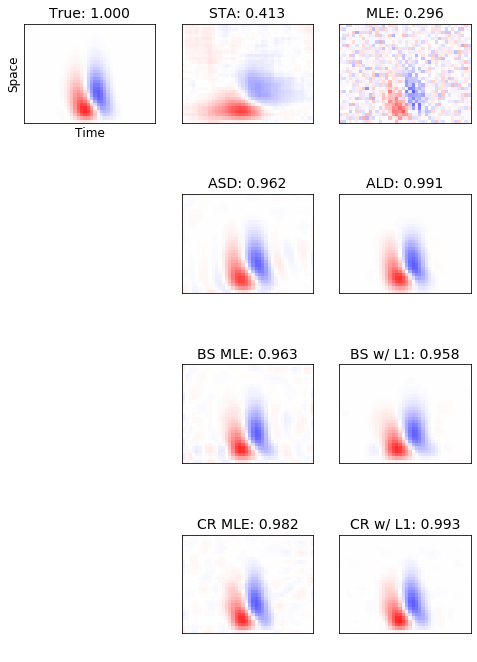

In [9]:
fig, ax = plt.subplots(4,3, figsize=(8, 12))
ax = ax.flatten()
labels = ['True', 'STA', 'MLE', '', 'ASD', 'ALD', 
                                '', 'BS MLE', 'BS w/ L1', 
                                '', 'CR MLE', 'CR w/ L1']
for ii, w in enumerate([k, cr.w_sta, cr.w_mle, 
                        0, asd.w_opt, ald.w_opt , 
                        0, bs.w_spl, bs.w_opt,
                        0, cr.w_spl, cr.w_opt]):
    
    if np.ndim(w) == 0:
        ax[ii].axis('off')
        continue
    
    w = w.reshape(dims) 
    w_norm =  w /np.linalg.norm(w)
    ax[ii].imshow(w_norm, cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax[ii].set_title("{0}: {1:.3f}".format(labels[ii], r2_score(k_norm.flatten(), w_norm.flatten())), fontsize=14)
    ax[ii].set_xticks([])
    ax[ii].set_yticks([])
ax[0].set_xlabel('Time', fontsize=12)
ax[0].set_ylabel('Space', fontsize=12)

Numbers indicate the r2 score of the true RF and the retrieved RF.